## Scikit-ribo manuscript analysis 

In [64]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr, spearmanr, ttest_ind, levene, f_oneway
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
import csv
from statsmodels import robust
import matplotlib.gridspec as gridspec
from statsmodels.formula.api import ols
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

sns.set(style="ticks", color_codes=True, font_scale=2)
snsRed, snsBlue, snsGreen, snsPurple, snsOrange = sns.color_palette("Set1", n_colors=5, desat=.5)
snsGray = sns.color_palette("Set1", n_colors=9, desat=.5)[8]

### Define data locations

In [65]:
protein_quant = "../Data/Lawless_2016.csv.cleaned.csv"
protein_degradation = "../Data/Christiano_2014.csv.cleaned.csv"
rna_halflife = "../Data/Geisberg_2014.csv.cleaned.csv"
kallisto_ribo = "../Data/kallisto_riboseq_abundance.tsv"
kallisto_rna = "../Data/kallisto_rnaseq_abundance.tsv"
#skr_weinberg_fn = "/seq/schatz/hfang/Projects/RiboSeq/Weinberg_2015/new_te_analysis/genesTE.csv"
#skr_weinberg_fn = "/seq/schatz/hfang/Projects/RiboSeq/Weinberg_2015/new_te_analysis/SRR1049521/lambda_min/genesTE.csv"
#skr_weinberg_fn = "../Data/skr_weinberg_geneTE.csv"
# skr_weinberg = "/seq/schatz/hfang/Projects/RiboSeq/Weinberg_2015/new_te_analysis/new_testing/genesTE.csv"
skr_weinberg = "../Data/skr_weinberg_genesTE.csv"
skr_codon = "../Data/skr_weinberg_codons.csv"

sgdGene_bed = "../Data/Yeast.sacCer3.sgdGene.cds.bed"
sgdGene_codons = "../Data/Yeast.sacCer3.sgdGene.codons.df"
weinberg_codon = "../Data/Weinberg_2016_codon.csv"
gene_tAI = "../Data/SacCer_stAIcalc_Sabi_Tuller.txt"
tRNA_abundance = "../../Paper/Data/microarray_tRNA_abundance.csv"
codon_tAI = "../Data/tAI.csv"
codon_stAI = "../Data/Yeast_codon_stAI.csv"

###  Import data

In [66]:
DFs = {} # a dict to save DFs
lst = [skr_weinberg, kallisto_ribo, kallisto_rna, weinberg_codon, skr_codon, codon_tAI, tRNA_abundance, 
       gene_tAI, protein_degradation, sgdGene_codons, protein_quant, rna_halflife] 
for i in lst:
    DFs[i] = pd.read_table(i, header=0)

DFs[codon_stAI] = pd.read_table(codon_stAI, header=0, sep=",")
DFs[sgdGene_bed] = pd.read_table(sgdGene_bed, sep="\t",
                                 names=['chr', 'start', 'end', 'gene', 'score', 'strand', 'thickStart',
                                        'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])

In [67]:
# compute TE from rpkm
DFs[kallisto_ribo]["rpkm_ribo"] = DFs[kallisto_ribo]["est_counts"] * (10 ** 9) / (DFs[kallisto_ribo]["length"] * \
                                  np.sum(DFs[kallisto_ribo]["est_counts"]))
DFs[kallisto_rna]["rpkm_rna"] = DFs[kallisto_rna]["est_counts"] * (10 ** 9) / (DFs[kallisto_rna]["length"] * \
                                np.sum(DFs[kallisto_rna]["est_counts"]))

DFs["weinburg"] = pd.merge(DFs[kallisto_ribo], DFs[kallisto_rna], on="target_id", suffixes=["_ribo","_rna"])
DFs["weinburg"] = DFs["weinburg"][(DFs["weinburg"]["tpm_ribo"] > 0) & (DFs["weinburg"]['tpm_rna'] > 0)]
DFs["weinburg"]['log2_TE'] = np.log2(DFs["weinburg"]["rpkm_ribo"] / DFs["weinburg"]["rpkm_rna"])
DFs["weinburg"]["log2_TE"] = (DFs["weinburg"]["log2_TE"] - np.median(DFs["weinburg"]["log2_TE"])) / np.log(2)
# save to dict
DFs["RPKM"] = DFs["weinburg"].copy()
DFs["scikit-ribo"] = DFs[skr_weinberg].copy()

### 1. TE comparsion: scikit-ribo vs. rpkm

#### (1) RPKM derived log(TE) was negatively skewed, whike scikit-ribo reported balanced distribution

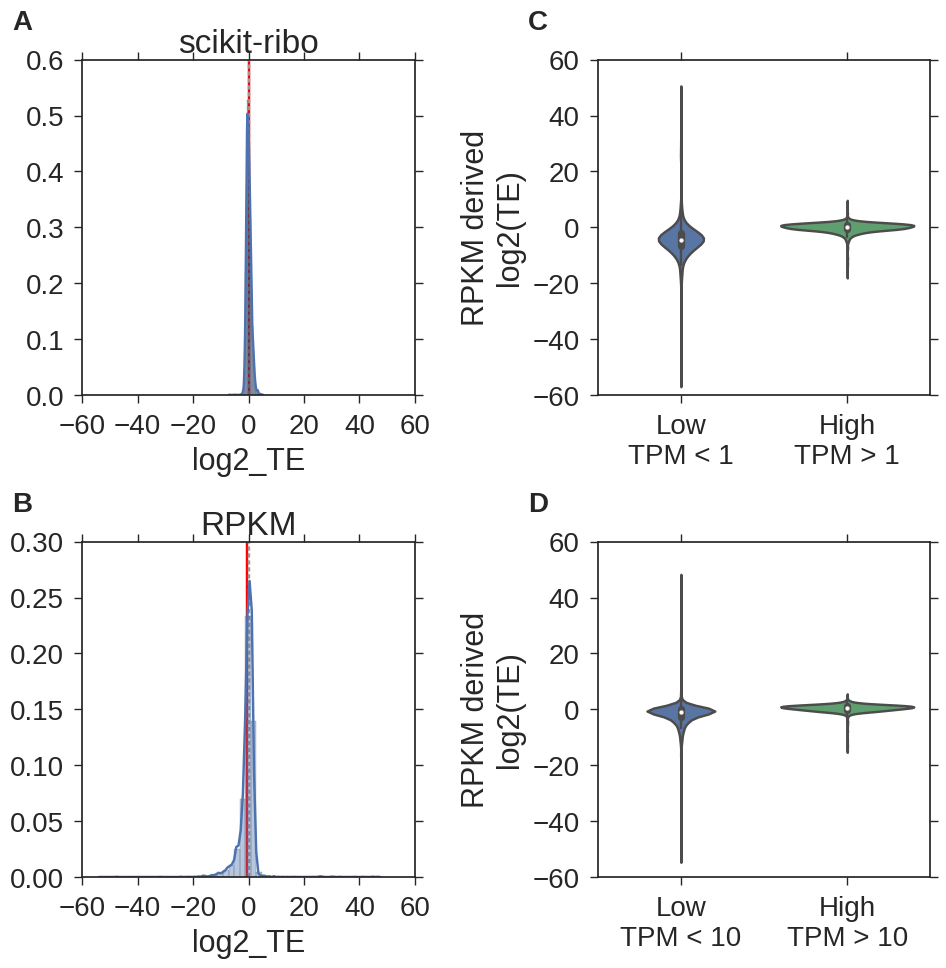

In [68]:
fig = plt.figure(figsize=(10, 10))
subplotOrder = [1, 3, 2, 4]

samples = ('scikit-ribo', 'RPKM')
for i, label in enumerate(('A', 'B')):
    sample = samples[i]
    idx = subplotOrder[i]
    ax = plt.subplot(2, 2, idx)
    ax.set_title(sample)
    ax = sns.distplot(DFs[sample]['log2_TE'])
    ax.set(xlim=(-60, 60))
    ax.axvline(np.mean(DFs[sample]['log2_TE']), color="red", zorder=-1)
    ax.axvline(0, color="#999999", dashes=[3,2], zorder=-1)
    ax.text(-0.15, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

TPM_cutoffs = [1, 10]
for i, label in enumerate(('C', 'D')):
    idx = subplotOrder[i+2]
    cutoff = TPM_cutoffs[i]
    tmp = DFs["RPKM"].copy()
    tmp["abundance"] = np.where((tmp["tpm_ribo"] > cutoff) & (tmp["tpm_rna"] > cutoff), "High", "Low") 
    ax = plt.subplot(2, 2, idx)
    ax = sns.violinplot(x="abundance", y="log2_TE", data=tmp)
    ax.set(ylim= [-60,60])
    ax.set_xticklabels(['Low\nTPM < ' + str(cutoff), 'High\nTPM > '+ str(cutoff)])
    ax.set_ylabel('RPKM derived\nlog2(TE)')
    ax.text(-0.15, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS1_weinburg_log2TE.pdf")
plt.show()

In [69]:
print("Mean of log2(TE)")
for i, label in enumerate(('A', 'B')):
    sample = samples[i]
    print(sample, ":", np.mean(DFs[sample]['log2_TE']))

Mean of log2(TE)
scikit-ribo : 0.1127988253719658
RPKM : -0.481474304907841


#### (2) Low abundance genes' TEs have high dispersion 

In [70]:
cutoff = 10
DFs["RPKM"]["abundance"] = np.where((DFs["RPKM"]["tpm_ribo"] > cutoff) & (DFs["RPKM"]["tpm_rna"] > cutoff), 
                                    "High", "Low") 
low_abundance_log2_TE = DFs["RPKM"][DFs["RPKM"]["abundance"]=="Low"]["log2_TE"]
high_abundance_log2_TE = DFs["RPKM"][DFs["RPKM"]["abundance"]=="High"]["log2_TE"]
levene_test_variance = levene(low_abundance_log2_TE, high_abundance_log2_TE)
print("Levene test of equal variance, p-value:", levene_test_variance[1])
print("Ratio of s.d.:", np.std(low_abundance_log2_TE) / np.std(high_abundance_log2_TE))

low_abundance_range = np.ptp(low_abundance_log2_TE)
high_abundance_range = np.ptp(high_abundance_log2_TE)
print("Ranges of log2(TE)", low_abundance_range, high_abundance_range)
print("Ratio of log2(TE) ranges:", low_abundance_range / high_abundance_range)

print("MAD of low abundance :", robust.mad(low_abundance_log2_TE))
print("MAD of high abundance :", robust.mad(high_abundance_log2_TE))

Levene test of equal variance, p-value: 3.38660609072e-89
Ratio of s.d.: 3.0361791942753382
Ranges of log2(TE) 99.7252369717 19.8455113934
Ratio of log2(TE) ranges: 5.02507771127
MAD of low abundance : 1.88449207871
MAD of high abundance : 1.00900706659


#### (3) Scikit-ribo quality control step removed extremely low abundance genes

In [71]:
# combine data
DFs["TE"] = pd.merge(DFs["scikit-ribo"], DFs["RPKM"], left_on=["gene"], right_on=["target_id"], 
                     suffixes=["_skr","_rpkm"])
DFs["excluded"] = pd.merge(DFs["RPKM"], DFs["scikit-ribo"], left_on=["target_id"], right_on=["gene"], 
                           suffixes=["_rpkm","_skr"], how="left")
DFs["excluded"]["category"] = np.where(DFs["excluded"]["gene"].isnull(), "Excluded", "Included") 

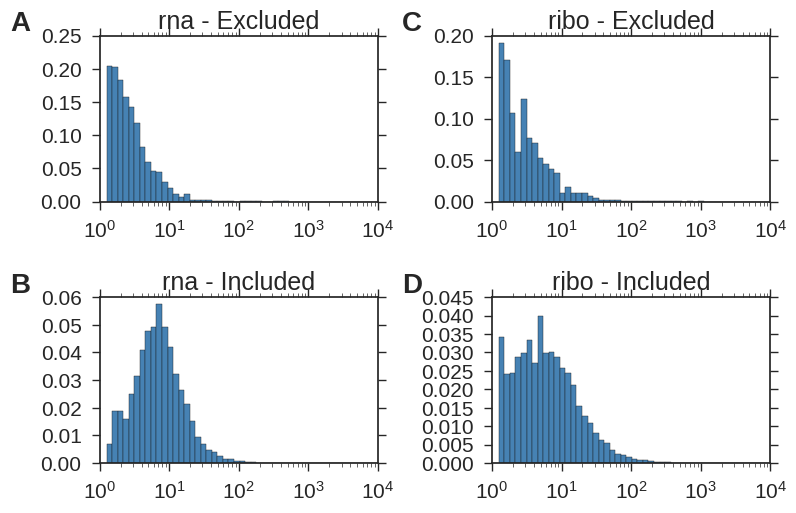

In [72]:
sns.set(style="ticks", color_codes=True, font_scale=1.5)
bins=np.logspace(0.1, 4.0, 50)
categories = ["Excluded", "Included"]

for i, label in enumerate(('A', 'B')):
    library = "rna"
    idx = subplotOrder[i]
    category = categories[i]
    ax = plt.subplot(2, 2, idx)
    ax.set_title(library + " - " +  category)
    tmp = DFs["excluded"].copy()
    ax.hist(tmp[tmp["category"]==category]["tpm_" + library], color="steelblue", bins=bins, normed=True)
    ax.set_xscale('log')
    ax.text(-0.25, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    plt.tight_layout()

for i, label in enumerate(('C', 'D')):
    library = "ribo"
    idx = subplotOrder[i+2]
    category = categories[i]
    ax = plt.subplot(2, 2, idx)
    ax.set_title(library + " - " + category)
    tmp = DFs["excluded"].copy()
    ax.hist(tmp[tmp["category"]==category]["tpm_" + library], color="steelblue", bins=bins, normed=True)
    ax.set_xscale('log')
    ax.text(-0.25, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    plt.tight_layout()

plt.savefig("../Figures/Supplemental/FigureS2_weinburg_scikit-ribo_qc_tpm.pdf")
sns.set(style="ticks", color_codes=True, font_scale=2)

### 2. codon elongation rates

In [73]:
DFs["codons"] = pd.merge(DFs[skr_codon], DFs[weinberg_codon], on="codon")
DFs["codons"] = pd.merge(DFs["codons"], DFs[codon_tAI], on="codon")
DFs["codons"] = pd.merge(DFs["codons"], DFs[codon_stAI], on="codon")
DFs["codons"] = pd.merge(DFs["codons"], DFs[tRNA_abundance], on="codon")
DFs["codons"]["codon_ER"] = 1 / DFs["codons"]["codon_dwell_time"]
DFs["codons"]["tRNA_abundance"] = DFs["codons"]["tRNA_abundance"] * 100 / np.sum(DFs["codons"]["tRNA_abundance"])

In [74]:
codon_corr = round(pearsonr(DFs["codons"]["Weinberg_dwell_time"], DFs["codons"]["codon_dwell_time"])[0], 2)
tAI_corr   = round(spearmanr(DFs["codons"]["tAI"], DFs["codons"]["codon_ER"])[0], 2)
tRNA_corr  = round(spearmanr(DFs["codons"]["tRNA_abundance"], DFs["codons"]["codon_ER"])[0], 2)
stAI_corr  = round(spearmanr(DFs["codons"]["stAI"], DFs["codons"]["codon_ER"])[0], 2)
codon_corrs = [tAI_corr, tRNA_corr, stAI_corr]
print("Correlation with Weinberg et al: ", codon_corr)
print("Correlation with tAI: ", tAI_corr)
print("Correlation with tRNA abundance", tRNA_corr)
print("Correlation with stAI: ", stAI_corr)

Correlation with Weinberg et al:  0.99
Correlation with tAI:  0.54
Correlation with tRNA abundance 0.47
Correlation with stAI:  0.15


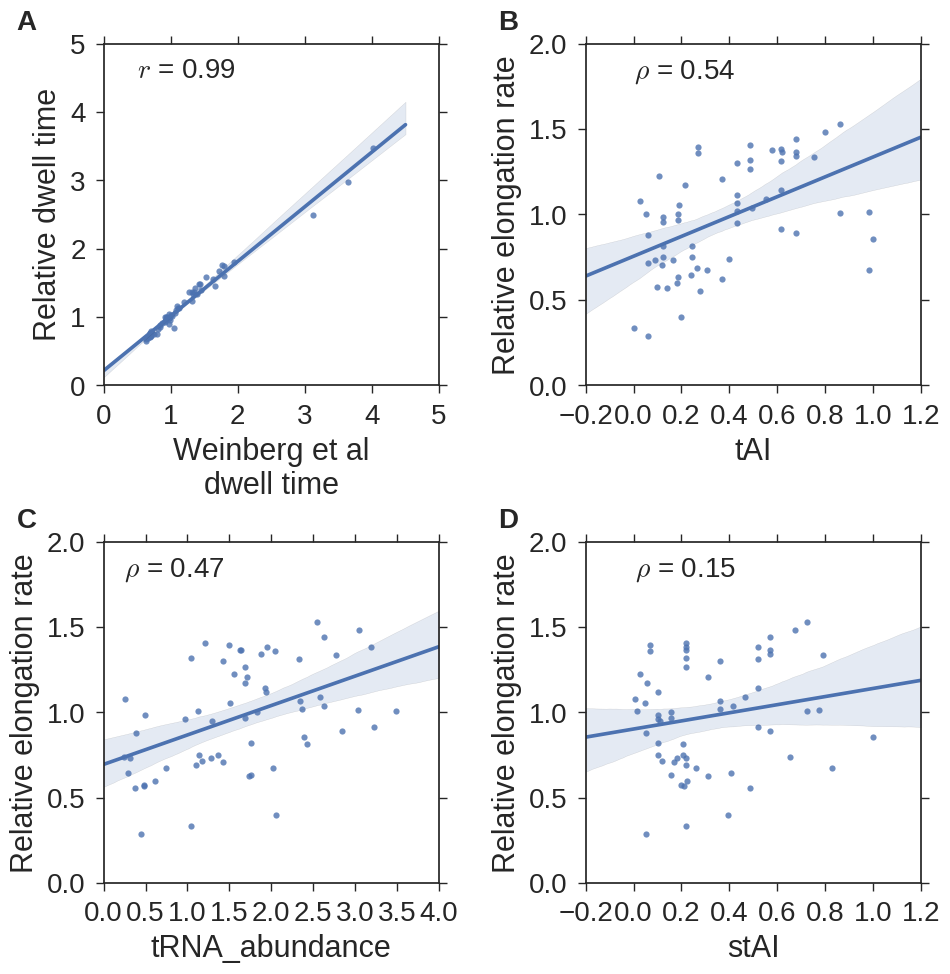

In [75]:
# plot codon rates
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(2, 2, 1)
g = sns.regplot(x="Weinberg_dwell_time", y="codon_dwell_time", data=DFs["codons"], 
                scatter_kws={"s": 20 }, ax=ax, label="label")
ax.set_ylabel('Relative dwell time')
ax.set_xlabel("Weinberg et al\ndwell time")
plt.text(0.5, 4.5, r"$r$ = " + str(codon_corr), fontsize=20)
plt.text(-0.2, 1.1, "A", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax.set(xlim=(0, 5), ylim=(0, 5))

colNames=["tAI", "tRNA_abundance", "stAI"]
for i, label in enumerate(('B', 'C', 'D')):
    ax = plt.subplot(2, 2, i+2)
    colName = colNames[i]
    ax.set(ylim=(0, 2))
    sns.regplot(x=colName, y="codon_ER", data=DFs["codons"], scatter_kws={"s": 20}, ax=ax, label="label")
    ax.set_ylabel('Relative elongation rate')
    ax.set_xlabel(colName)
    ax.text(np.min(DFs["codons"][colName]), 1.8, r"$\rho$ = " + str(codon_corrs[i]), fontsize=20)
    ax.text(-0.2, 1.1, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()    
plt.savefig("../Figures/Figure3_codon_corr.pdf")

### 3. Pairwise comparisons showed that scikit-ribo:
#####     a) is robust to low abudance genes 
#####     b) corrected biases due to codon biases and secondary structure

In [76]:
# For plotting, fix any values below -10 to -10
DFs["TE"]["log2_TE_rpkm_adj"] = np.where(DFs["TE"]["log2_TE_rpkm"] < -8, -7.5, DFs["TE"]["log2_TE_rpkm"]) 
DFs["TE"]['deltaTE'] = DFs["TE"]["log2_TE_skr"] - DFs["TE"]["log2_TE_rpkm"]

In [77]:
# define regions
DFs["TE"].loc[DFs["TE"]['deltaTE'] > 0.5, 'region'] = "above"
DFs["TE"].loc[DFs["TE"]['deltaTE'] < -0.5, 'region'] = "below"
DFs["TE"].loc[(DFs["TE"]['deltaTE'] >= -0.5) & (DFs["TE"]['deltaTE'] <= 0.5), 'region'] = "middle"
# define sign of log2(TE)
DFs["TE"]["skr_sign"] = np.where(DFs["TE"]['log2_TE_skr'] > 0, "+", "-") 
DFs["TE"]["rpkm_sign"] = np.where(DFs["TE"]['log2_TE_rpkm'] > 0, "+", "-") 
# find outliers
DFs["TE"]["outlier"] = np.where(DFs["TE"]["log2_TE_rpkm"] < -8, "outlier", "not_outlier") 

In [78]:
# define colors
colors = [snsGreen, snsGray, snsOrange]
regions = ["above", "middle", "below"]

In [79]:
# stem loops
tmp = DFs[sgdGene_codons].groupby("gene").pair_prob.sum().reset_index(name="stem_loops")
tmp["stem_loops"] = tmp["stem_loops"].astype(int)
DFs["TE"] = pd.merge(DFs["TE"], tmp, on="gene")
DFs["TE"]["stem_loop_bin"] = np.where(DFs["TE"]["stem_loops"] < 4, DFs["TE"]["stem_loops"], ">=4") 

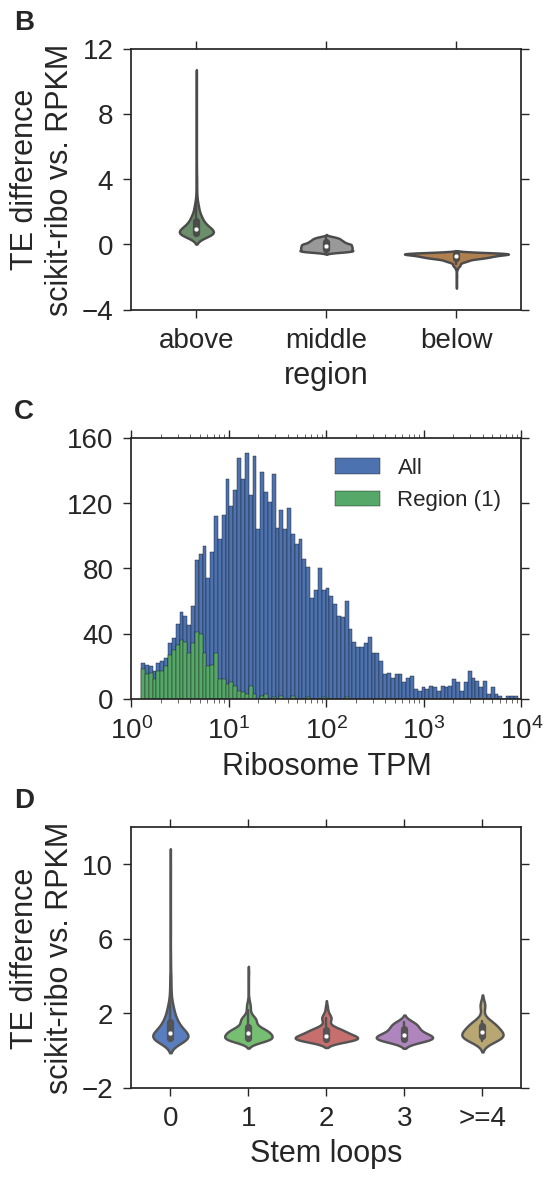

In [80]:
# plot comparisons
fig = plt.figure(figsize=(6, 12))

ax2 = plt.subplot(3, 1, 1)
ax2 = sns.violinplot(x='region', y='deltaTE', data=DFs["TE"], palette=colors, order=regions)
ax2.set_yticks(range(-4,16,4))
ax2.text(-0.25, 1.15, "B", transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
plt.ylabel('TE difference\nscikit-ribo vs. RPKM')

bins=np.logspace(0.1, 4.0, 100)
ax3 = plt.subplot(3, 1, 2)
ax3.text(-0.25, 1.15, "C", transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax3 = plt.hist(DFs["TE"]["tpm_ribo"], bins=bins, label='All')
region_one = DFs["TE"][(DFs["TE"]["region"]=="above") & (DFs["TE"]["skr_sign"]=="-")]
ax3 = plt.hist(region_one["tpm_ribo"], bins=bins, label='Region (1)')
plt.legend(fontsize=16)
plt.gca().set_yticks(range(0,200,40))
plt.gca().set_xlabel('Ribosome TPM')
plt.gca().set_xscale("log")

ax4 = plt.subplot(3, 1, 3)
ax4.text(-0.25, 1.15, "D", transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax4 = sns.violinplot(x="stem_loop_bin", y="deltaTE", data=DFs["TE"][(DFs["TE"]["region"]=="above")], 
                     palette="muted", order=["0","1","2","3",">=4"]) 
ax4.set_yticks(range(-2,14,4))
plt.ylabel('TE difference\nscikit-ribo vs. RPKM')
plt.gca().set_xlabel('Stem loops')

plt.tight_layout()
plt.savefig("../Figures/Figure4BCD.pdf")

In [81]:
lm = ols('deltaTE ~ stem_loop_bin', data=DFs["TE"][(DFs["TE"]["region"]=="above")]).fit()
table =  sm.stats.anova_lm(lm)
print(table)

                  df      sum_sq   mean_sq         F    PR(>F)
stem_loop_bin    4.0   16.915683  4.228921  4.834979  0.000733
Residual       892.0  780.188916  0.874651       NaN       NaN


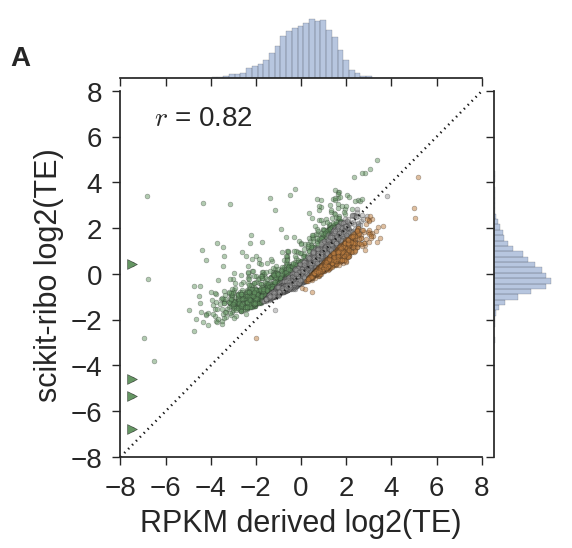

In [82]:
# compute correlation
TE_corr = round(pearsonr(DFs["TE"]["log2_TE_rpkm"], DFs["TE"]["log2_TE_skr"])[0] ,2)

g1 = sns.jointplot(x="log2_TE_rpkm_adj", y="log2_TE_skr", data=DFs["TE"], xlim= [-8,8], ylim= [-8,8], 
                   marker='.', s=50, alpha=0, stat_func=None)
g1 = (g1.set_axis_labels("RPKM derived log2(TE)", "scikit-ribo log2(TE)"))
x0, x1 = g1.ax_joint.get_xlim()
y0, y1 = g1.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g1.ax_joint.plot(lims, lims, ':k')

for color, region in zip(colors, regions):
    df = DFs["TE"][DFs["TE"]["region"] == region]
    g1.x, g1.y = df.log2_TE_rpkm_adj, df.log2_TE_skr
    g1.plot_joint(plt.scatter, marker='.', c=color, s=50, alpha=0.5)

g1.x = DFs["TE"][DFs["TE"]["outlier"] == "outlier"].log2_TE_rpkm_adj, 
g1.y = DFs["TE"][DFs["TE"]["outlier"] == "outlier"].log2_TE_skr
g1.plot_joint(plt.scatter, marker='>', c=snsGreen, s=50, alpha=1)

plt.text(-6.5, 6.5, r"$r$ = " + str(TE_corr), fontsize=20)
plt.text(-12, 10, "A", fontsize=20, fontweight='bold', va='top', ha='right')

plt.savefig("../Figures/Figure4A_compare_skr_rpkm_TE.pdf")

In [83]:
print(DFs["TE"].groupby("region").size())

region
above      897
below     1060
middle    3151
dtype: int64


In [84]:
# log2(TE) > 2
highTE_genes = DFs["TE"][DFs["TE"]["log2_TE_skr"] >= 2][["gene"]]
highTE_genes.to_csv(path_or_buf="../Data/highestTE_genes.csv", sep='\t', 
                    header=True, index=False, quoting=csv.QUOTE_NONE)
# export BED to local
highTE_genes_bed = pd.merge(DFs[sgdGene_bed], highTE_genes, on="gene")
highTE_genes_bed["start_new"] = highTE_genes_bed["start"] - 50
highTE_genes_bed["end_new"] = highTE_genes_bed["start"] + 6
highTE_genes_bed = highTE_genes_bed[["chr", "start_new", "end_new", "gene", "score", "strand"]]
highTE_genes_bed.to_csv(path_or_buf="../Data/highestTE_genes.bed", sep='\t', 
                        header=False, index=False, quoting=csv.QUOTE_NONE)

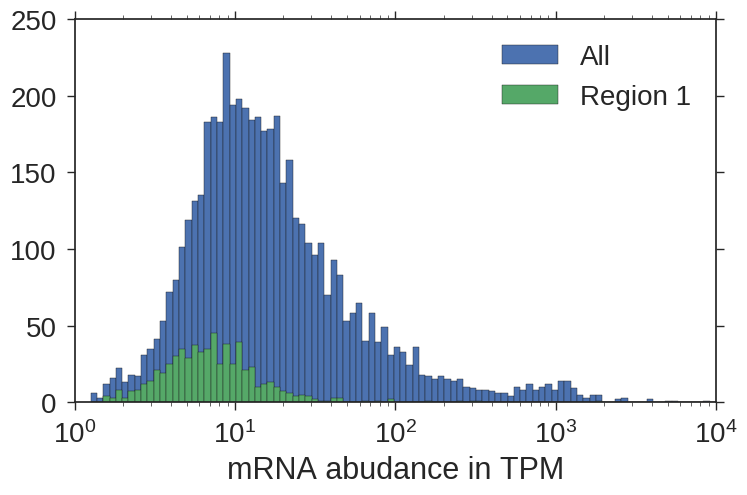

In [85]:
# histogram mRNA abundance
bins=np.logspace(0.1, 4.0, 100)
plt.hist(DFs["TE"]["tpm_rna"], bins=bins, label='All')
plt.hist(region_one["tpm_rna"], bins=bins, label='Region 1')
plt.xlabel('mRNA abudance in TPM')
plt.gca().set_xscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS4_upperLeft_mRNA_TPM.pdf")

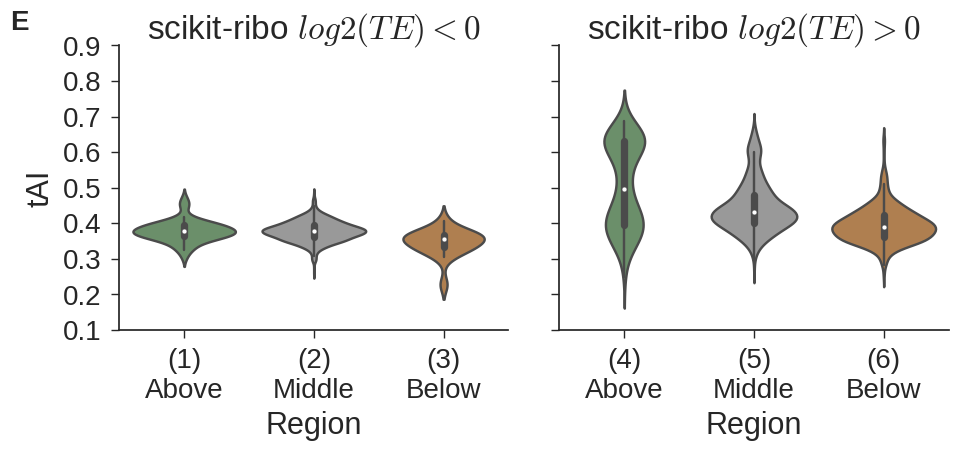

In [86]:
# get tAI & stAI
DFs["TE"] = pd.merge(DFs[gene_tAI], DFs["TE"], left_on="genes_id", right_on="gene")

g = sns.FacetGrid(DFs["TE"][(DFs["TE"]["tpm_ribo"] > 10) & (DFs["TE"]["tpm_rna"] > 10)], 
                  col="skr_sign", size=5, sharex=False, col_order=["-", "+"])
g = g.map(sns.violinplot, "region", "tAI", order=regions, palette=colors)
g.axes[0,0].set_xticklabels(["(1)\nAbove","(2)\nMiddle", "(3)\nBelow"])
g.axes[0,1].set_xticklabels(["(4)\nAbove","(5)\nMiddle", "(6)\nBelow"])
g.axes[0,0].set_xlabel("Region")
g.axes[0,1].set_xlabel("Region")

for ax, title in zip(g.axes.flat, ['scikit-ribo $log2(TE)<0$', 'scikit-ribo $log2(TE)>0$']):
    ax.set_title(title)

g.axes[0,0].text(-1.2, 1.0, "E",  fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig("../Figures/Figure4E.pdf")

In [87]:
lm = ols('deltaTE ~ C(region)', data=DFs["TE"][(DFs["TE"]["skr_sign"]=="-")]).fit()
table =  sm.stats.anova_lm(lm)
# print(table)
for sign in ["+", "-"]:
    print("scikit-ribo log2(TE) sign:", sign)
    for i in [("above","middle"),("middle", "below"),("above","below")]:
        l, r = i
        tmp = DFs["TE"][(DFs["TE"]["skr_sign"]==sign)&(DFs["TE"]["tpm_ribo"]>10) & (DFs["TE"]["tpm_rna"]>10)]
        a = tmp[tmp["region"] == l]["tAI"] 
        b = tmp[tmp["region"] == r]["tAI"] 
        p = ttest_ind(a,b)
        print(l, "VS.", r, "p-value:" ,p[1])
    print("\n")

scikit-ribo log2(TE) sign: +
above VS. middle p-value: 1.61204341619e-17
middle VS. below p-value: 5.12099633924e-55
above VS. below p-value: 2.44077502895e-59


scikit-ribo log2(TE) sign: -
above VS. middle p-value: 0.950207565451
middle VS. below p-value: 1.54329094798e-06
above VS. below p-value: 0.000299448289992




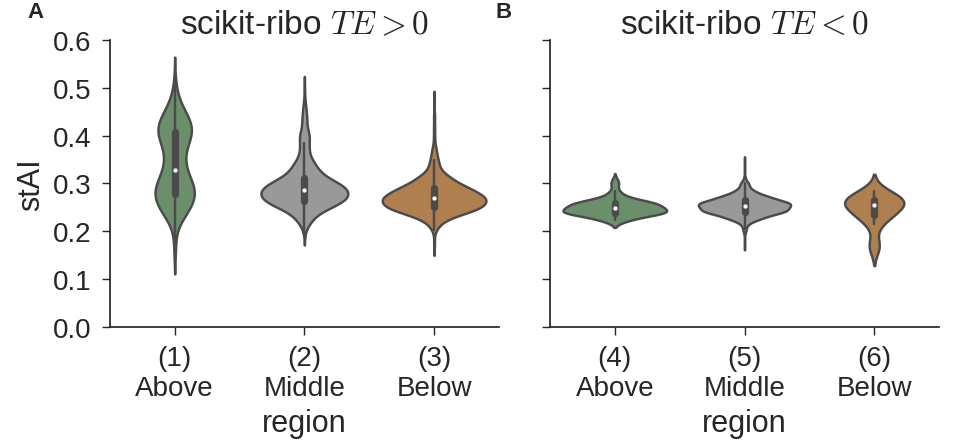

In [88]:
g = sns.FacetGrid(DFs["TE"][(DFs["TE"]["tpm_ribo"]>10) & (DFs["TE"]["tpm_rna"]>10)], 
                  col="skr_sign", size=5, sharex=False)
g = g.map(sns.violinplot, "region", "stAI", order=regions, palette=colors)
g.axes[0,0].set_xticklabels(["(1)\nAbove","(2)\nMiddle", "(3)\nBelow"])
g.axes[0,1].set_xticklabels(["(4)\nAbove","(5)\nMiddle", "(6)\nBelow"])
g.axes[0,0].text(-0.25, 1.7, "A", transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
g.axes[0,1].text(1.25, 1.7, "B", transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

for ax, title in zip(g.axes.flat, ['scikit-ribo $TE>0$', 'scikit-ribo $TE<0$']):
    ax.set_title(title)

plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS5_stAI.pdf")

### 3. Validation with SRM data

In [89]:
skr_validation = pd.merge(DFs[skr_weinberg], DFs[kallisto_rna], left_on="gene", right_on="target_id")
skr_validation["log2_protein_skr"] = np.log2(skr_validation["tpm"]) + skr_validation["log2_TE"]

In [90]:
skr_validation = pd.merge(skr_validation, DFs[protein_quant], left_on="gene", right_on="protein")
skr_validation = pd.merge(skr_validation, DFs["TE"], on="gene")
skr_validation["log2_protein_srm"] = np.log2(skr_validation["SRM_protein_quant"])
skr_validation_low = skr_validation[skr_validation["tpm"] < 100]

rpkm_validation = pd.merge(DFs[kallisto_ribo], DFs[protein_quant], left_on="target_id", right_on="protein")
rpkm_validation = pd.merge(rpkm_validation, DFs["TE"], how="left", left_on="target_id", right_on="gene")
rpkm_validation = rpkm_validation[rpkm_validation["tpm"] > 0] 
rpkm_validation["log2_protein_rpkm"] = np.log2(rpkm_validation["tpm"])
rpkm_validation["log2_protein_srm"] = np.log2(rpkm_validation["SRM_protein_quant"])
rpkm_validation_low = rpkm_validation[rpkm_validation["tpm"] < 100]

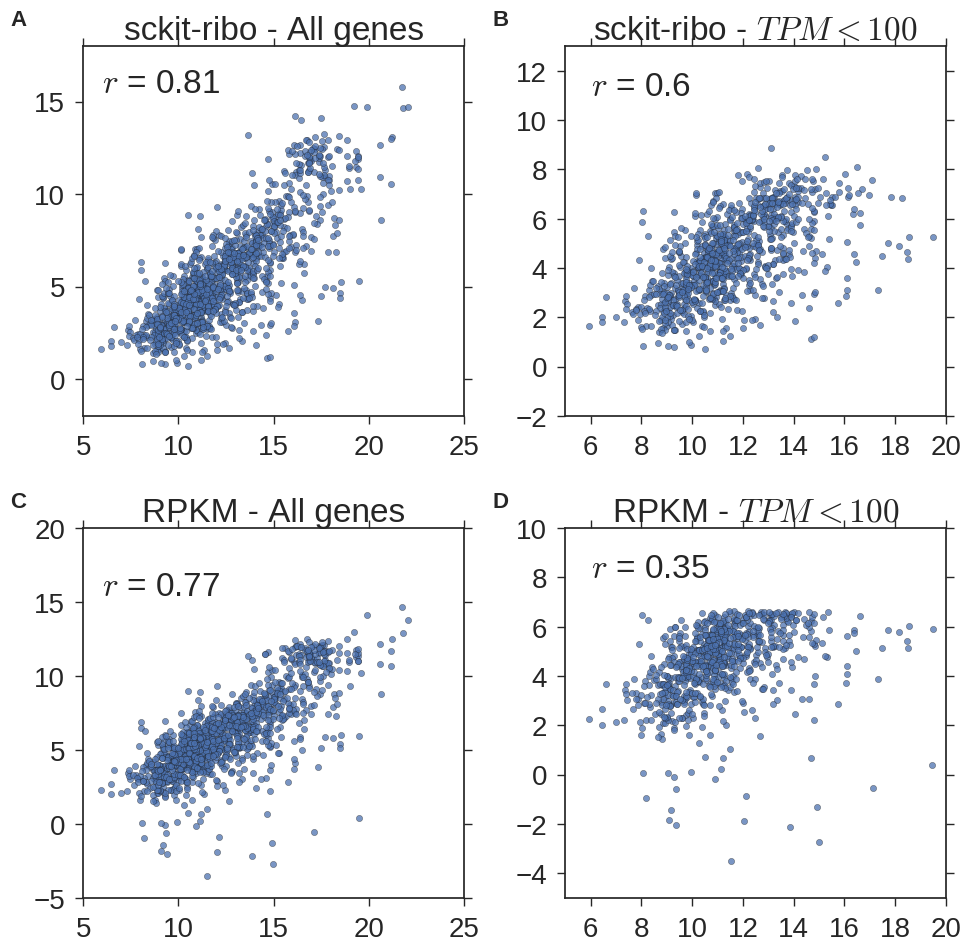

In [91]:
fig = plt.figure(figsize=(10, 10))

ax1 = plt.subplot(2, 2, 1)
skr_srm_corr = round(pearsonr(skr_validation["log2_protein_srm"], skr_validation["log2_protein_skr"])[0] ,2)
ax1.scatter(x="log2_protein_srm", y="log2_protein_skr", data=skr_validation, alpha=0.75, edgecolor="k")
plt.xlim(5,25)
plt.ylim(-2,18)
ax1.text(6, 15.5, r"$r$ = " + str(skr_srm_corr))
ax1.text(-0.15, 1.1, "A", transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax1.set_title("sckit-ribo - All genes")

ax2 = plt.subplot(2, 2, 2)
skr_srm_low_corr = round(pearsonr(skr_validation_low["log2_protein_srm"], skr_validation_low["log2_protein_skr"])[0] ,2)
ax2.scatter(x="log2_protein_srm", y="log2_protein_skr", data=skr_validation_low, alpha=0.75, edgecolor="k")
plt.xlim(5,20)
plt.ylim(-2,13)
ax2.text(6, 11, r"$r$ = " + str(skr_srm_low_corr))
ax2.text(-0.15, 1.1, "B", transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.set_title("sckit-ribo - $TPM<100$")

rpkm_srm_corr = round(pearsonr(rpkm_validation["log2_protein_srm"], rpkm_validation["log2_protein_rpkm"])[0] ,2)
ax3 = plt.subplot(2, 2, 3)
ax3.scatter(x="log2_protein_srm", y="log2_protein_rpkm", data=rpkm_validation, alpha=0.75, edgecolor="k")
plt.xlim(5,25)
plt.ylim(-5,20)
ax3.text(6, 15.5, r"$r$ = " + str(rpkm_srm_corr))
ax3.text(-0.15, 1.1, "C", transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax3.set_title("RPKM - All genes")

rpkm_srm_corr_low = round(pearsonr(rpkm_validation_low["log2_protein_srm"], 
                                   rpkm_validation_low["log2_protein_rpkm"])[0] ,2)
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(x="log2_protein_srm", y="log2_protein_rpkm", data=rpkm_validation_low, alpha=0.75, edgecolor="k")
plt.xlim(5,20)
plt.ylim(-5,10)
ax4.text(6, 8, r"$r$ = " + str(rpkm_srm_corr_low))
ax4.text(-0.15, 1.1, "D", transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax4.set_title("RPKM - $TPM<100$")

plt.tight_layout()
plt.savefig("../Figures/Figure5_validation.pdf")

In [92]:
skr_validation = pd.merge(skr_validation, DFs[protein_degradation], on="gene")
skr_validation["log2_protein_skr_adj"] = np.log2(skr_validation["tpm"]) + skr_validation["log2_TE"] - \
                                         np.log2(skr_validation["protein_degradation"])  

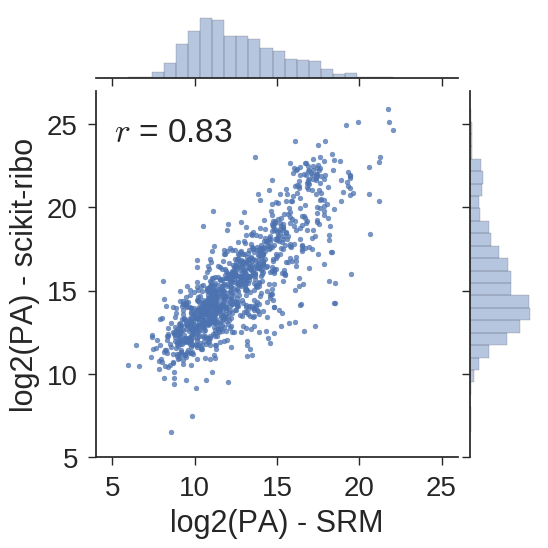

In [93]:
skr_srm_adj_corr = round(pearsonr(skr_validation["log2_protein_srm"], skr_validation["log2_protein_skr_adj"])[0] ,2)
g1 = sns.jointplot(x="log2_protein_srm", y="log2_protein_skr_adj", data=skr_validation, 
                   xlim= [4,26], ylim= [5,27], marker='.', s=50, alpha=0.75, stat_func=None)
g1 = (g1.set_axis_labels("log2(PA) - SRM", "log2(PA) - scikit-ribo"))

plt.text(-800, 24, r"$r$ = " + str(skr_srm_adj_corr))
plt.savefig("../Figures/Supplemental/FigureS6_validation.pdf")